To Do:
- Bollinger bands differences
- Create wrapper function to in bulk create TAs
- Transplant useful functions from previous project into this directory, such as the methods to concatenate seperate datasets and backtest
- More clearly define the initial trading paradigm

In [27]:
# Import packages
%load_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from datetime import date
import os
import time
import pickle
from termcolor import colored 
import talib
import matplotlib.pyplot as plt

from alpha_vantage.timeseries import TimeSeries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Import files
%aimport alphavantage_datapull.load_tickers

from alphavantage_datapull.load_tickers import *

In [5]:
# Check package versions

print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.0.0


In [6]:
# Check GPU recognition

from tensorflow.python.client import device_lib
print("GPUs: ", device_lib.list_local_devices(), "\n")

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10829062561989101816
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4855863705
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1052388215695720784
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
] 



In [7]:
# Import API keys

from API_keys import Quandl_api_key, AlphaVantage_api_key

In [8]:
# Load S&P100 Tickers

sp100_ticker_df = load_sp100_tickers()
display(sp100_ticker_df.head())

,ticker,name
0,ABBV,AbbVie Inc.
1,ABT,Abbott Laboratories
2,ACN,Accenture
3,ADBE,Adobe Inc.
4,AGN,Allergan


In [9]:
# Set up TimeSeries

ts = TimeSeries(key=AlphaVantage_api_key, output_format='pandas')

In [10]:
# Creat data cache daily folder if necessary

today = str(date.today())

data_cache = Path("data_cache/") / today

# Create folder for today
if not os.path.exists(data_cache):
    os.mkdir(data_cache)

# Create API call counter for today
api_call_counter_file_path = data_cache / "api_call_counter_file.pickle"

if not os.path.exists(api_call_counter_file_path):
    api_call_counter = 0
    with open(api_call_counter_file_path, 'wb') as f:
        pickle.dump(api_call_counter, f)
else:
    with open(api_call_counter_file_path, 'rb') as f:
        api_call_counter = pickle.load(f)
        
print("Value of api_call_counter: ", api_call_counter)

Value of api_call_counter:  103


In [87]:
counter_delta = 0
for i, ticker in enumerate(sp100_ticker_df.ticker):
    if(api_call_counter == 500):
        print(colored("Reached the maximum api calls allowed for today", 'magenta'))
        break
        
    # Check if data already exists
    save_path_file = data_cache / (ticker + "_intraday.csv")
    if os.path.exists(save_path_file):
        print(colored("Data for " + ticker + " already exists", 'green'))        
        continue
    
    # API call limit 5 / minute
    if((counter_delta % 5 == 0) and (counter_delta != 0)) : 
        print(colored("+ API call per min limit - Sleeping for one minute", 'yellow'))
        time.sleep(60)
    
    # Pull data
    print("Pulling: ", ticker)
    try:
        data, meta_data = ts.get_intraday(ticker, interval="1min", outputsize='full')
    except ValueError: 
        print(colored("- ValueError - Sleeping for one minute", 'red'))
        time.sleep(60)
        try:
            data, meta_data = ts.get_intraday(ticker, interval="1min", outputsize='full')
        except:
            print(colored(("- Exception - Could not pull " + ticker), 'red'))
            api_call_counter += 2
            counter_delta += 2
            continue

        
    save_path_file = data_cache / (ticker + "_intraday.csv")

    data.to_csv(save_path_file)
    
    api_call_counter += 1
    counter_delta += 1
    
with open(api_call_counter_file_path, 'wb') as f:
    pickle.dump(api_call_counter, f)
    
print(colored("*** Finished task ***", 'green'))
print("Value of api_call_counter: ", api_call_counter)

Data for ABBV already exists
Data for ABT already exists
Data for ACN already exists
Data for ADBE already exists
Data for AGN already exists
Data for AIG already exists
Data for ALL already exists
Data for AMGN already exists
Data for AMT already exists
Data for AMZN already exists
Data for AXP already exists
Data for BA already exists
Data for BAC already exists
Data for BIIB already exists
Data for BK already exists
Data for BKNG already exists
Data for BLK already exists
Data for BMY already exists
Pulling:  BRK.B
- ValueError - Sleeping for one minute
- Exception - Could not pull BRK.B
Data for C already exists
Data for CAT already exists
Data for CHTR already exists
Data for CL already exists
Data for CMCSA already exists
Data for COF already exists
Data for COP already exists
Data for COST already exists
Data for CSCO already exists
Data for CVS already exists
Data for CVX already exists
Data for DD already exists
Data for DHR already exists
Data for DIS already exists
Data for 

In [142]:
# Plat with technical indicators

amzn_df = open_single_intraday('AMZN', data_cache)
display(amzn_df.head())

Opening path  data_cache\2020-04-19\AMZN_intraday.csv


,date,1. open,2. high,3. low,4. close,5. volume
0,2020-04-13 09:31:00,2040.1500,2042.3690,2038.0000,2040.5200,105361.0
1,2020-04-13 09:32:00,2042.1400,2050.0000,2041.3000,2046.8000,28795.0
2,2020-04-13 09:33:00,2046.9900,2049.1499,2045.9600,2045.9600,16970.0
3,2020-04-13 09:34:00,2050.8101,2050.8101,2050.8101,2050.8101,28544.0
4,2020-04-13 09:35:00,2052.5349,2052.5349,2052.3501,2052.3501,18870.0


In [143]:
# Sandbox

close = amzn_df['4. close']
upper, middle, lower = talib.BBANDS(close, matype=talib.MA_Type.T3)

print(type(amzn_df['date'][0]))
print(amzn_df['date'][0])

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2020-04-13 09:31:00


[0, 390, 778, 1167, 1557]


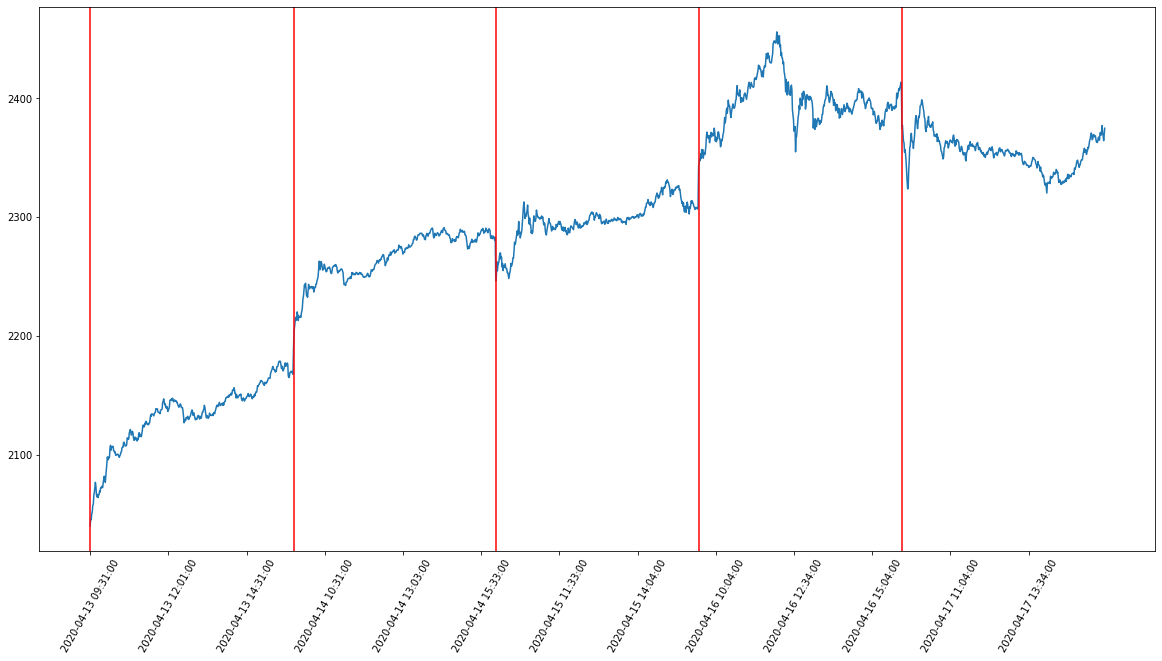

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
datetime_list = amzn_df['date'].apply(str)
open_time_args = []
for i, datetime in enumerate(datetime_list):
    if '9:31' in datetime:
        open_time_args.append(i)
        
dummy_values = np.arange(0,len(amzn_df['date']),1)
ax.plot(dummy_values, close)
plt.xticks(dummy_values[::150],amzn_df['date'][::150]) # rotation=60)
plt.xticks(rotation=60)

# Return all args of date where time contains 9:31
for x in open_time_args:
    ax.axvline(x=x, c='r')
plt.show()


